# Smooth an Easy Digital Negatives LUT .cube File
This notebook allows you to smooth the curve contained within a LUT .cube file, which is generally obtained from the Easy Digital Negatives website to use in making alternative process digital negatives.

### How To Run This Notebook
The code in this notebook is organized into cells.  Each cell can be run independently, providing all prerequisite imports have been done and all variables exist.  However, **it is recommended that you run all code cells in sequence.**  

The only exception is possibly the [Smooth the Data and Plot the Results](#Smooth-the-Data-and-Plot-the-Results) cell, which you may choose to run more than once if you wish to revise your smoothing factor prior to saving the new .cube file.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from tkinter import Tk
from tkinter import filedialog
from tkinter import simpledialog

In [2]:
def read_cube_to_list(in_file):
    cube_values = []
    with open(in_file, 'r') as cf:
        for line in cf:
            if line.startswith("#"):
                continue
            if line.startswith("TITLE"):
                continue
            if line.startswith("LUT"):
                continue
            if line.startswith("DOMAIN"):
                continue
            if line:
                cube_values.append(float(line.split(" ")[0]))
    return cube_values

# Get the .cube File to Process

In [3]:
# get the Easy Digital Negatives CSV file to process
root = Tk()
root.wm_attributes('-topmost', 1)
root.withdraw()
cube_file = filedialog.askopenfilename(title=".cube File to Smooth", filetypes=[("LUT files", "*.cube")])
min_val = 0.0
max_val = 1.0
cube_values = read_cube_to_list(cube_file)
print("Smoothing: {}".format(cube_file))

Smoothing: C:/Digital_Photos/Alt_Process_Files/Jupyter_Notebooks/Processing/HL_Curve16.cube


# Smooth the Data and Plot the Results
The following cell smooths the refined curve using a Univariate Spline with a smoothing factor.  You will be prompted to specify the smoothing factor.  Common values fall within the 0.1 to 0.001 range, and the larger this number, the smoother the resulting curve.  

**If, after running this cell, you do not like the resulting smoothed curve, you may re-run this cell as many times as needed to narrow down the smoothing factor you like best.**

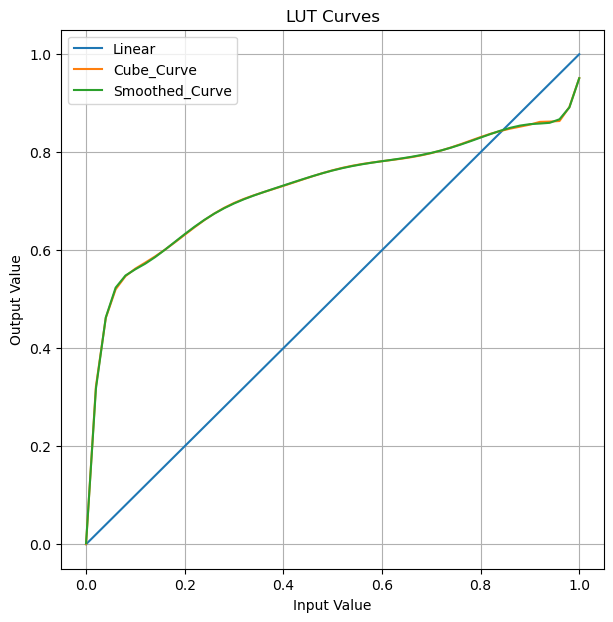

In [6]:
value_steps = []
num_steps = len(cube_values)
step_increment = 1.0 / (num_steps - 1)
for i in range(num_steps):
    value_steps.append(round(min_val + (i * step_increment), 4))
linear_line = pd.Series(value_steps, index=value_steps)
curve_line = pd.Series(cube_values, index=value_steps)
cube_df = pd.DataFrame({'Linear':value_steps, 'Cube_Curve':curve_line}, index=value_steps)
cube_df.head(num_steps)
smoothing_factor_value = simpledialog.askfloat(title="Smoothing Factor", prompt="Enter a smoothing factor. This will probably be a very small number less than 1.\nBigger numbers mean a smoother result.\nIf you enter 0, no further smoothing will be performed.", initialvalue=0.001)
k_value = simpledialog.askinteger(title="Number of Knots (K)", prompt="Enter the number of knots to use.\nMore knots means more able to capture shape.\nWhen in doubt, use 5", initialvalue=5)
if smoothing_factor_value == None:
    smoothing_factor_value = 0.001
spl = UnivariateSpline(cube_df['Linear'], cube_df['Cube_Curve'], k=k_value, s=25)
spl.set_smoothing_factor(smoothing_factor_value)
cube_df['Smoothed_Curve'] = spl(value_steps)
plt.close("all")
cube_plot = cube_df.plot(grid=True, title='LUT Curves', figsize=(7,7))
cube_plot.set_xlabel("Input Value")
cube_plot.set_ylabel("Output Value")
plt.show()

# Save the New Curve to a .cube File

In [7]:
cube_filename = simpledialog.askstring("Output .cube File Name", "Enter the name for the output .cube file (no .cube extension)")
cube_filename = cube_filename.replace(" ", "_")
out_cube = os.path.join(os.path.dirname(cube_file), "{}.cube".format(cube_filename))
with open(out_cube, 'w') as cube:
    cube.write("#Created by: Easy Digital Negatives plus Jupyter\nTITLE  \"{}\"\nLUT_1D_SIZE {}\nDOMAIN_MIN 0.0 0.0 0.0\nDOMAIN_MAX 1.0 1.0 1.0\n#LUT data points\n".format(cube_filename, num_steps))
    line_template = "{:<08} {:<08} {:<08}\n"
    for i, row in cube_df.iterrows():
        val = round(row['Smoothed_Curve'], 6)
        cube.write(line_template.format(val, val, val))
    cube.write("#END data\n")
print("Saved {}".format(out_cube))

Saved C:/Digital_Photos/Alt_Process_Files/Jupyter_Notebooks/Processing\HL_Curve16.cube
